# Подгрузка пакетов и данных

In [1]:
cd ..

/Users/n.barsukov/WebstormProjects/ml-bug-detector


In [2]:
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm

from gensim.models.word2vec import Word2Vec

from shared.consts import FUNCTIONS_JSON_PROPERTIES_NAMES, PATH_TO_FUNCTIONS_STORAGE_JSON, PATH_TO_WORD2VEC_MODEL
from shared.helpers import (
    get_key_in_func_creation_dict, # получаем ключ из словаря/json c объявлениями функциями
    get_func_name_from_key # из ключа от словаря/json c объявлениями функциями извлекаем имя функции
)

Загрузим уже построенную модель Word2Vec

In [3]:
word2VecModel = Word2Vec.load(PATH_TO_WORD2VEC_MODEL)

Загрузим JSON, в котором мы сложили названия функций (и названия их арггументов)

In [4]:
functions_storage_dictionary = json.load(open(PATH_TO_FUNCTIONS_STORAGE_JSON))

# Отделение объявления функций от их использования

Функции с одним и тем же названием могут быть объявлены по-разному, поэтому объявления функций будут склдываться в словарь по принципу:

<div style="text-align: center; font-weight: bold;">Имя репозитория + имя функции</div>

Функции **get_key_in_func_creation_dict** и **get_func_name_from_key** помогут нам с этим правилом

In [5]:
def find_all_functions_creations(func_storage_dic):
    func_creation_dic = {}
    
    for filePath in func_storage_dic.keys():
        for function in func_storage_dic[filePath]:
            if (
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE] == 'FunctionDeclaration' or
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE] == 'FunctionExpression'
               ):
                func_name = function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME]
                func_creation_dict_key = get_key_in_func_creation_dict(func_name, filePath)
                if func_creation_dict_key in func_creation_dic:
                    pass
                    #print(func_creation_dict_key, 'уже есть в словаре')
                func_creation_dic[func_creation_dict_key] = {
                    f"{FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES}" : function[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES],
                    f"{FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH}": filePath
                }
    
    return func_creation_dic

In [6]:
func_creation_dic = find_all_functions_creations(functions_storage_dictionary)

А теперь находим все ВЫЗОВЫ функций и смотрим, насколько их аргументы отличны объявления функции

In [7]:
def find_all_func_executions(func_storage_dic, func_creation_dic, onlyInDictionary = True):
    func_exec_storage = []
    
    for filePath in func_storage_dic.keys():
        for function in func_storage_dic[filePath]:
            func_name = function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME]
            func_creation_dict_key = get_key_in_func_creation_dict(func_name, filePath)
            
            if (
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_TYPE] == 'CallExpression' and # должна быть вызовом функции
                len(function[FUNCTIONS_JSON_PROPERTIES_NAMES.ARGS_NAMES]) > 0 and # должна иметь хоть один аргумент
                (func_creation_dict_key in func_creation_dic or not onlyInDictionary)# должна быть в нашем словаре
            ):
                function[FUNCTIONS_JSON_PROPERTIES_NAMES.FILE_PATH] = filePath
                func_exec_storage.append(function)
    
    return func_exec_storage

In [8]:
func_exec_storage = find_all_func_executions(functions_storage_dictionary, func_creation_dic)

In [9]:
print('Размер словаря с объявлениями функций: ', len(func_creation_dic))
print('Размер массива с вызовами функций: ', len(func_exec_storage))

Размер словаря с объявлениями функций:  158133
Размер массива с вызовами функций:  110682


Словарь с объявлениями функций - словарь, в котором ключ - название функции, а значение – массив с названиями переданных аргументов.

Пример: функция с названием **confirmDelete**

In [10]:
func_creation_dic[get_key_in_func_creation_dict('confirmDelete', 'scripts/Block8/PHPCI/public/assets/js/phpci.js')]

{'argumentsNames': ['url', 'subject', 'reloadAfter'],
 'filePath': 'scripts/Block8/PHPCI/public/assets/js/phpci.js'}

Массив с вызовами функций состоит из словарей следующего формата

In [11]:
list(filter(lambda func_exec: func_exec[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME] == 'sleep', func_exec_storage))

[{'type': 'CallExpression',
  'argumentsNames': ['millis'],
  'functionName': 'sleep',
  'filePath': 'scripts/replit/jsrepl/tools/closure-compiler/trunk/lib/rhino/src/mozilla/js/rhino/toolsrc/org/mozilla/javascript/tools/debugger/test.js'},
 {'type': 'CallExpression',
  'argumentsNames': [1000],
  'functionName': 'sleep',
  'filePath': 'scripts/replit/jsrepl/tools/closure-compiler/trunk/lib/rhino/src/mozilla/js/rhino/toolsrc/org/mozilla/javascript/tools/debugger/test.js'}]

# Класс для вызовов функций

In [12]:
from shared.classes import FunctionExecution

Импортированный класс определяет схожесть названий аргументов (в их векторной форме) в вызванной функции:

- c названиями аргументов (на тех же позициях) в момент объявления функции (массив с циферкам)
- векторную близость названий аргументов с названием функции (массив с циферкам)
- общую векторную близость с названиями аргументами в момент объявления функции (одна циферка)

Посмотрим, как это работает на примере

In [13]:
def find_func_exec_and_compare_with_func_creation(funcName):
    example_func_execs = list(
        filter(lambda func: func[FUNCTIONS_JSON_PROPERTIES_NAMES.FUNC_NAME].endswith(funcName), func_exec_storage)
    )
    for example_func_exec in example_func_execs:
        exec_func = FunctionExecution(example_func_exec, func_creation_dic, word2VecModel)

        print('Вызов функции:', exec_func.func_name, 'c аргументами', exec_func.args_names)
        print('Функция же была объявлена с словаре с аргументами:', exec_func.args_in_creation_dic)
        print(exec_func.args_similarity_with_creation_args)
        print('_________________________________________________')

In [14]:
find_func_exec_and_compare_with_func_creation('updateLine')
find_func_exec_and_compare_with_func_creation('windowSearch')

Вызов функции: updateLine c аргументами ['lastLine', '', 'lastSpans', 'estimateHeight']
Функция же была объявлена с словаре с аргументами: ['line', 'text', 'markedSpans', 'estimateHeight']
[0.40866297, None, -0.024005493, 1.0]
_________________________________________________
Вызов функции: windowSearch c аргументами ['strSelectorName', None, 900, 'strTop', 'strLeft', 'strWindowName', 'parameters', None]
Функция же была объявлена с словаре с аргументами: ['strPage', 'strHeight', 'strWidth', 'strTop', 'strLeft', 'strWindow', 'parameters', 'strValueID']
[0.4237818, None, None, 1.0, 1.0, None, 1.0, None]
_________________________________________________
Вызов функции: windowSearch c аргументами ['strSelectorName', 450, 650, 'strTop', 'strLeft', 'strWindowName', 'parameters', 'strValueID']
Функция же была объявлена с словаре с аргументами: ['strPage', 'strHeight', 'strWidth', 'strTop', 'strLeft', 'strWindow', 'parameters', 'strValueID']
[0.4237818, None, None, 1.0, 1.0, None, 1.0, 0.999999

# Реализация алгоритма по поиску сомнительных мест

Идея максимально проста. Проходим по массиву вызовов функции.

- По названию функции определяем в словаре с объявлениями функций, с какими названиями аргументов была объявлена эта функция
- Для каждой пары аргументов (название аргумента в момент вызовы функции и название аргумента в момент объявление функции) считаем близость их названий в векторной форме с помощью уже построенной модели word2Vec (это будет значение 0 до 1)
- Аналогично считаем близость каждого аргумента с названием функции
- Считаем общую близость аргументов (в момент вызовы функции и в момент объявление функции)
- Если все схожести меньше заданного порога (threshold), то выбрасываем предупреждение пользователю

### Threshold

In [15]:
MIN_SIMILARITY_THRESHOLD = 0.1

In [16]:
def if_any_arg_below_threshold(list_with_sims, min_sim_threshold = MIN_SIMILARITY_THRESHOLD):
    if not list_with_sims:
        return False
    
    is_below_threshold_args_similarities = list(
        map(lambda x: x and x < min_sim_threshold, list_with_sims))

    return any(is_below_threshold_args_similarities)

Порог не должен быть большой, потому что модели важно достичь высокого precision, а не recall.

Если наш алгоритм будет часто беспокоить пользователя по пустякам, предупреждая об ошибках там, где их нет (false positive), то нашим алгоритмом просто никто не будет пользоваться. Нужно беспокоить программиста только прям в самых вероятных случаях наличия ошибки. Ведь программисты люди ленивые и занятые... 

### Поиск сомнительных мест

In [17]:
warnings_exec_functions_storage = []
for func_exec_item in func_exec_storage:
    func_exec = FunctionExecution(func_exec_item, func_creation_dic, word2VecModel)
    
    if len(func_exec.args_names) != len(func_exec.args_in_creation_dic):
        continue
    
    if_any_dissims_with_creation_arg = if_any_arg_below_threshold(func_exec.args_similarity_with_creation_args)
    if_any_dissims_with_func_name = if_any_arg_below_threshold(func_exec.args_similarity_with_func_name)
    if_total_args_sim_with_creation_args_low = func_exec.total_args_sim_with_creation_args < MIN_SIMILARITY_THRESHOLD
    
    if if_any_dissims_with_creation_arg and if_any_dissims_with_func_name and if_total_args_sim_with_creation_args_low:
        warnings_exec_functions_storage.append(func_exec)

In [18]:
print('Было зафиксировано', len(warnings_exec_functions_storage), 'предупреждений')

Было зафиксировано 1374 предупреждений


In [19]:
for func_exec in warnings_exec_functions_storage[:5]:
    print('В файле', func_exec.func_path, 'проверь функцию', func_exec.func_name)
    print('Она вызвана с аргументами', func_exec.args_names)
    print('Но вот объявлена функция со следующими аргументами:')
    print(func_exec.args_in_creation_dic)
    print('Попарная схожесть аргументов (c названиями в объявленной функции):',func_exec.args_similarity_with_creation_args)
    print('Общая схожесть (c названиями в объявленной функции):', func_exec.total_args_sim_with_creation_args)
    print('Попарная схожесть аргументов c названием функции:', func_exec.args_similarity_with_func_name)
    print('_____________')

В файле scripts/01org/web-simulator/lib/ripple/ui/plugins/settings-dialog.js проверь функцию fill
Она вызвана с аргументами ['build', 'projectPath']
Но вот объявлена функция со следующими аргументами:
['action', 'prop']
Попарная схожесть аргументов (c названиями в объявленной функции): [0.07789196, -0.021467714]
Общая схожесть (c названиями в объявленной функции): 0.08319147
Попарная схожесть аргументов c названием функции: [0.038251348, 0.03182174]
_____________
В файле scripts/01org/web-simulator/lib/ripple/ui/plugins/settings-dialog.js проверь функцию fill
Она вызвана с аргументами ['build', 'remoteInspector']
Но вот объявлена функция со следующими аргументами:
['action', 'prop']
Попарная схожесть аргументов (c названиями в объявленной функции): [0.07789196, None]
Общая схожесть (c названиями в объявленной функции): 0.08061557
Попарная схожесть аргументов c названием функции: [0.038251348, None]
_____________
В файле scripts/01org/web-simulator/lib/ripple/xhr/jsonp.js проверь функци

### Разные названия аргументов,  но модель поняла, что они похожи

Для контраста посмотрим кейсы, которые модель смогла определить как корректные (хотя имели РАЗНЫЕ названия аргументов)

In [20]:
class RANGE_THRESHOLDS:
    MIN = 0.3
    MAX = 0.9

def if_all_args_in_range_thresholds(
    list_with_sims,
    min_threshold = RANGE_THRESHOLDS.MIN,
    max_threshold = RANGE_THRESHOLDS.MAX
):
    if not list_with_sims:
        return False
    
    is_above_threshold_args_similarities = list(
        map(lambda x: x and (x > min_threshold and x < max_threshold), list_with_sims)
    )

    return all(is_above_threshold_args_similarities)

In [21]:
success_exec_func_storage = []

for func_exec_item in func_exec_storage:
    func_exec = FunctionExecution(func_exec_item, func_creation_dic, word2VecModel)
    
    if len(func_exec.args_names) != len(func_exec.args_in_creation_dic):
        continue
    
    if_all_similar_with_creation = if_all_args_in_range_thresholds(func_exec.args_similarity_with_creation_args)
    if_all_similar_with_func_name = if_all_args_in_range_thresholds(func_exec.args_similarity_with_func_name)
    
    if if_all_similar_with_creation and if_all_similar_with_func_name:
        success_exec_func_storage.append(func_exec)

In [22]:
already_shown = []

for func_exec in success_exec_func_storage:
    if func_exec.func_name in already_shown:
        continue
    already_shown.append(func_exec.func_name)
    
    print('В файле', func_exec.func_path, 'функция', func_exec.func_name)
    print('Была вызвана с аргументами', func_exec.args_names)
    print('А объявлена функция со следующими аргументами:')
    print(func_exec.args_in_creation_dic)
    print('Попарная схожесть аргументов (c названиями в объявленной функции):',func_exec.args_similarity_with_creation_args)
    print('Общая схожесть (c названиями в объявленной функции):', func_exec.total_args_sim_with_creation_args)
    print('Попарная схожесть аргументов c названием функции:', func_exec.args_similarity_with_func_name)
    print('_____________')

В файле scripts/QBurst/PenQ/PenQ/omni/chrome/toolkit/content/global/customizeToolbar.js функция toolboxChanged
Была вызвана с аргументами ['aProp']
А объявлена функция со следующими аргументами:
['aType']
Попарная схожесть аргументов (c названиями в объявленной функции): [0.36262286]
Общая схожесть (c названиями в объявленной функции): 0.36262286
Попарная схожесть аргументов c названием функции: [0.37223992]
_____________
В файле scripts/ReDEnergy/Browsercast/public/libs/js-beautify/beautify.js функция set_mode
Была вызвана с аргументами ['next_mode']
А объявлена функция со следующими аргументами:
['mode']
Попарная схожесть аргументов (c названиями в объявленной функции): [0.30677778]
Общая схожесть (c названиями в объявленной функции): 0.30677778
Попарная схожесть аргументов c названием функции: [0.64253885]
_____________
В файле scripts/YuqinShao/Tile_Based_WebGL_DeferredShader/DeferredShaderNonMRT/deferred.js функция setupQuad
Была вызвана с аргументами ['edge_prog']
А объявлена фун

### Диапозон значений топ-10 похожих слов для каждого слова в словаре

Определим, в каких диапозонах в среднем находится топ-10 слов

In [23]:
first_simalar_words_sims = []
tenth_simalar_words_sims = []
fiftieth_simalar_words_sims = []
hundredth_simalar_words_sims = []

sample_words_from_model_dic = word2VecModel.wv.index2entity[::300]

for wordIndex in tqdm(range(len(sample_words_from_model_dic))):
    word = sample_words_from_model_dic[wordIndex]
    most_similar_words = word2VecModel.wv.most_similar(word, topn=100)
    
    first_simalar_words_sims.append(most_similar_words[0][1])
    tenth_simalar_words_sims.append(most_similar_words[9][1])
    fiftieth_simalar_words_sims.append(most_similar_words[49][1])
    hundredth_simalar_words_sims.append(most_similar_words[99][1])

In [24]:
import numpy as np

top_1 = np.asarray(first_simalar_words_sims)
top_10 = np.asarray(tenth_simalar_words_sims)
top_50 = np.asarray(fiftieth_simalar_words_sims)
top_100 = np.asarray(hundredth_simalar_words_sims)

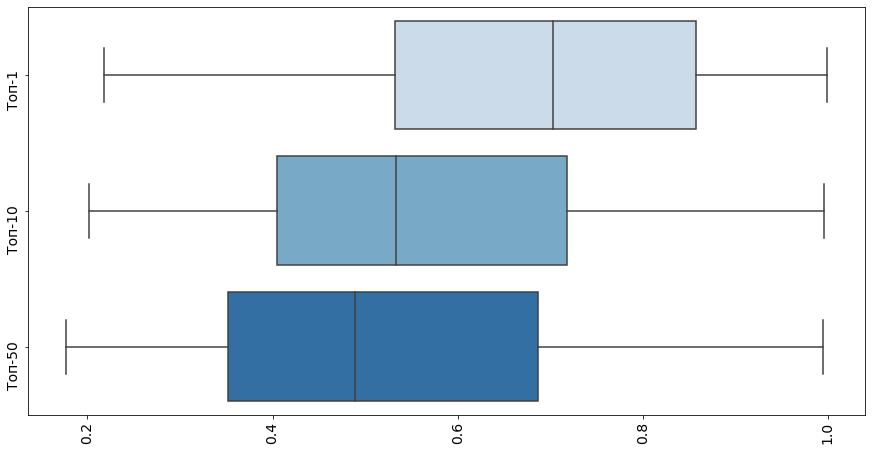

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7.5))
tops_sims_df = pd.DataFrame({
    'Топ-1': top_1,
    'Топ-10': top_10,
    'Топ-50': top_50,
    # 'Топ-100': top_100
})

tops_boxplot = sns.boxplot(data=tops_sims_df, orient='h', palette="Blues")
tops_boxplot.tick_params(labelsize=14, labelrotation = 90)

In [26]:
xticks = [
    0,
    round(np.median(top_50), 2),
    round(np.median(top_10), 2),
    round(np.median(top_1), 2),
    
    round(np.percentile(top_10, 25), 2),
    round(np.percentile(top_50, 25), 2),
    round(np.median(top_1), 2),
    
    round(np.percentile(top_1, 75), 2),
    1
]

tops_boxplot.set_xticks(xticks)
tops_boxplot.get_figure().savefig("top_sims.png", dpi=300)